In [2]:
! pip install gym==0.17.3 torch matplotlib numpy

  Using cached gym-0.17.3-py3-none-any.whl
  Using cached pyglet-1.5.0-py2.py3-none-any.whl.metadata (7.6 kB)
  Using cached cloudpickle-1.6.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   -- ------------------------------------- 14.7/199.4 MB 76.7 MB/s eta 0:00:03
   ----- ---------------------------------- 26.0/199.4 MB 65.7 MB/s eta 0:00:03
   ------- -------------------------------- 39.8/199.4 MB 64.9 MB/s eta 0:00:03
   ---------- ----------------------------- 54.3/199.4 MB 67.8 MB/s eta 0:00:03
   ------------- -------------------------- 68.9/199.4 MB 66.6 MB/s eta 0:00:02
   ---------------- ----------------------- 83.9/199.4 MB 66.9 MB/s eta 0:00:02
   ------------------- -------------------- 98.6/199.4 MB 67.7 MB/s eta 0:00:02
   ---------------------- ---------------- 113.2/199.4 MB 67.6 MB/s eta 0:00:02
   ------------------------- ------------- 127.9

State dimension: 3
Number of discrete actions: 5
Discrete action space: [-2. -1.  0.  1.  2.]

Starting Training...
Episode 50/1000 | Avg Reward (Last 100): -1149.25 | Epsilon: 0.778
Episode 100/1000 | Avg Reward (Last 100): -977.85 | Epsilon: 0.606
Episode 150/1000 | Avg Reward (Last 100): -749.95 | Epsilon: 0.471
Episode 200/1000 | Avg Reward (Last 100): -656.19 | Epsilon: 0.367
Episode 250/1000 | Avg Reward (Last 100): -554.44 | Epsilon: 0.286
Episode 300/1000 | Avg Reward (Last 100): -462.81 | Epsilon: 0.222
Episode 350/1000 | Avg Reward (Last 100): -384.55 | Epsilon: 0.173
Episode 400/1000 | Avg Reward (Last 100): -271.73 | Epsilon: 0.135
Episode 450/1000 | Avg Reward (Last 100): -236.72 | Epsilon: 0.105
Episode 500/1000 | Avg Reward (Last 100): -231.11 | Epsilon: 0.082
Episode 550/1000 | Avg Reward (Last 100): -183.34 | Epsilon: 0.063
Episode 600/1000 | Avg Reward (Last 100): -168.63 | Epsilon: 0.049
Episode 650/1000 | Avg Reward (Last 100): -172.93 | Epsilon: 0.038
Episode 700/1

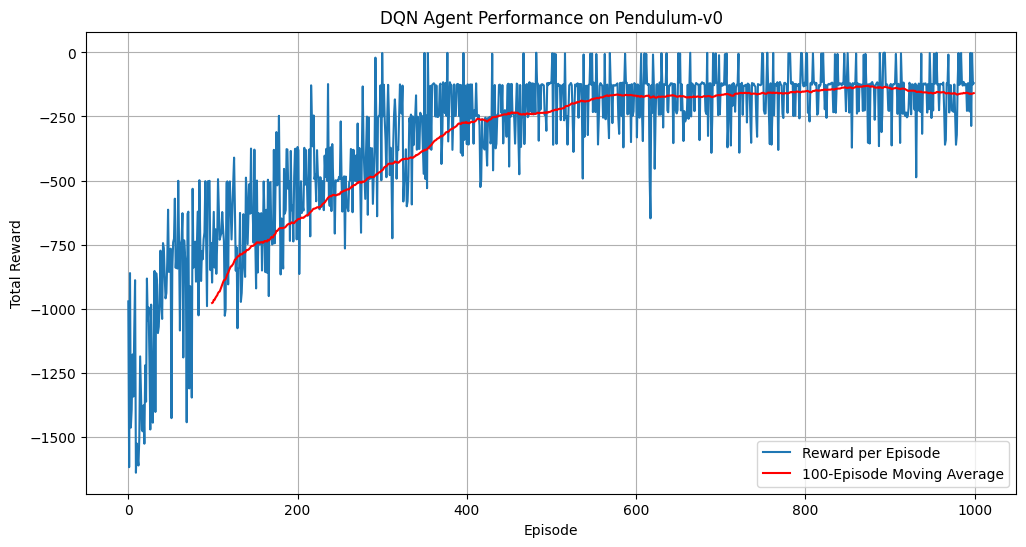

Average reward over the last 100 episodes: -158.89
Model weights saved to dqn_pendulum_weights.pth

Running demonstration with trained agent...
Total reward in demonstration episode: -7.40


C:\Users\p2435356\AppData\Local\Temp\ipykernel_16388\2065160575.py:298: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_agent.policy_net.load_state_dict(torch.load(MOD

In [3]:
# =============================================================================
# --- ST1504 DEEP LEARNING: ASSIGNMENT 2, PART B ---
#
# Task: Apply a Deep Q-Network (DQN) to solve the Pendulum-v0 environment.
#
# This script implements a DQN agent to balance an inverted pendulum.
# Key challenges addressed:
# 1.  Adapting DQN for a continuous action space via discretization.
# 2.  Implementing core DQN components: Replay Memory and a Target Network.
# 3.  Structuring the code for systematic hyperparameter tuning and evaluation.
#
# Environment: OpenAI Gym 0.17.3, Pendulum-v0
# Framework: PyTorch
# =============================================================================

# --- 1. SETUP AND IMPORTS ---
# Import necessary libraries.
# Ensure you have the correct versions installed, especially gym==0.17.3.
# pip install gym==0.17.3 torch matplotlib numpy

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque
import math
import matplotlib.pyplot as plt

# --- 2. HYPERPARAMETERS AND CONFIGURATION ---
# Centralizing hyperparameters makes them easy to find and tune, which is
# crucial for the systematic optimization required by the assignment. [2]

# Environment settings
ENV_NAME = 'Pendulum-v0'
# Per the assignment, ensure gym version 0.17.3 is used. [2]
env = gym.make(ENV_NAME)
STATE_DIM = env.observation_space.shape[0]  # Should be 3 for Pendulum-v0
ACTION_MAX = env.action_space.high[0]      # Max torque, typically 2.0
ACTION_MIN = env.action_space.low[0]       # Min torque, typically -2.0

# Discretization settings
# The core modification to apply DQN to this continuous environment. [2, 2]
# We will test if 5 bins is sufficient, as prompted in the notes. [2]
N_ACTION_BINS = 5

# DQN Agent hyperparameters
GAMMA = 0.99  # Discount factor for future rewards [3, 4]
LEARNING_RATE = 1e-3  # Learning rate for the Adam optimizer [5, 4]
BATCH_SIZE = 128  # Number of transitions sampled from the replay buffer [3, 4]
REPLAY_BUFFER_SIZE = 10000  # Max size of the replay buffer [5, 6]
TARGET_UPDATE_FREQUENCY = 500  # Steps between updating the target network [7, 5]

# Epsilon-greedy exploration strategy settings
EPS_START = 1.0  # Starting value of epsilon
EPS_END = 0.01  # Minimum value of epsilon
EPS_DECAY = 0.995  # Multiplicative factor for decaying epsilon per episode [3]

# Training settings
N_EPISODES = 1000  # Total number of episodes to train for
SEED = 42  # Random seed for reproducibility [8, 9]

# Set seed for all random number generators to ensure reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
env.seed(SEED)

# --- 3. ACTION SPACE DISCRETIZATION ---
# DQN requires a discrete action space. We convert the continuous torque
# range [-2.0, 2.0] into a finite number of bins. [10, 11]
discrete_action_space = np.linspace(ACTION_MIN, ACTION_MAX, N_ACTION_BINS)
print(f"State dimension: {STATE_DIM}")
print(f"Number of discrete actions: {N_ACTION_BINS}")
print(f"Discrete action space: {discrete_action_space}")


# --- 4. REPLAY MEMORY IMPLEMENTATION ---
# Stores agent's experiences to sample from for training. This breaks
# temporal correlations and improves data efficiency. [3, 12, 9]

# A named tuple to represent a single transition
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of the memory"""
        return len(self.memory)


# --- 5. DQN MODEL (Q-NETWORK) IMPLEMENTATION ---
# A simple Multi-Layer Perceptron (MLP) to approximate the Q-function.
# It takes a state and outputs a Q-value for each discrete action. [8, 3, 13]

class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        # A simple two-layer MLP is a good starting point for classic control. [8]
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


# --- 6. DQN AGENT IMPLEMENTATION ---
# Encapsulates the agent's logic: acting, learning, and managing networks.

class DQNAgent:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.epsilon = EPS_START

        # Initialize policy and target networks
        self.policy_net = QNetwork(state_dim, n_actions)
        self.target_net = QNetwork(state_dim, n_actions)
        self.update_target_net()  # Copy weights initially
        self.target_net.eval()  # Target network is only for inference

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(REPLAY_BUFFER_SIZE)
        self.steps_done = 0

    def select_action(self, state):
        """Selects an action using an epsilon-greedy policy."""
        if random.random() > self.epsilon:
            # Exploitation: choose the best action from the policy network
            with torch.no_grad():
                # state is a numpy array, convert to tensor for the network
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                # .max(1) returns (values, indices)
                return q_values.max(1)[1].item()
        else:
            # Exploration: choose a random action
            return random.randrange(self.n_actions)

    def learn(self):
        """Update the policy network using a batch of experiences."""
        if len(self.memory) < BATCH_SIZE:
            return  # Not enough experiences to learn yet

        # Sample a batch of transitions
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for details)
        batch = Transition(*zip(*transitions))

        # Create tensors for states, actions, rewards, and next_states
        state_batch = torch.FloatTensor(np.array(batch.state))
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1)

        # Handle non-final states
        non_final_mask = torch.tensor(tuple(s is not None for s in batch.next_state), dtype=torch.bool)
        non_final_next_states = torch.FloatTensor(np.array([s for s in batch.next_state if s is not None]))

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        next_state_values = torch.zeros(BATCH_SIZE)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        # Compute the expected Q values (TD Target)
        expected_state_action_values = (next_state_values.unsqueeze(1) * GAMMA) + reward_batch

        # Compute loss (Huber loss is often more stable than MSE)
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent them from exploding
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_net(self):
        """Copies the weights from the policy network to the target network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """Decay epsilon for the epsilon-greedy policy."""
        self.epsilon = max(EPS_END, self.epsilon * EPS_DECAY)


# --- 7. TRAINING LOOP ---
# This is the main loop where the agent interacts with the environment.

agent = DQNAgent(STATE_DIM, N_ACTION_BINS)
episode_rewards = []

print("\nStarting Training...")
for i_episode in range(N_EPISODES):
    state = env.reset()
    total_reward = 0
    
    # Pendulum-v0 runs for a fixed 200 steps per episode [2]
    for t in range(200):
        # Select and perform an action
        action_index = agent.select_action(state)
        torque_value = discrete_action_space[action_index]
        
        # The action passed to env.step must be a list or numpy array
        next_state, reward, done, _ = env.step([torque_value])
        total_reward += reward

        # Store the transition in replay memory
        # Note: action is the index, not the torque value
        agent.memory.push(state, action_index, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.learn()
        
        agent.steps_done += 1
        # Update the target network, copying all weights and biases in DQN
        if agent.steps_done % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_net()

        if done:
            break
            
    # Decay epsilon after each episode
    agent.decay_epsilon()
    
    episode_rewards.append(total_reward)

    # Logging
    if (i_episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {i_episode+1}/{N_EPISODES} | Avg Reward (Last 100): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f}")

print("Training complete.\n")


# --- 8. EVALUATION AND VISUALIZATION ---
# Plotting the results is crucial to evaluate the agent's performance. [2, 2]

plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Reward per Episode')
# Calculate and plot a moving average to see the trend
if len(episode_rewards) >= 100:
    moving_avg = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
    plt.plot(np.arange(99, len(episode_rewards)), moving_avg, label='100-Episode Moving Average', color='red')
plt.title('DQN Agent Performance on Pendulum-v0')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

if len(episode_rewards) >= 100:
    final_avg_reward = np.mean(episode_rewards[-100:])
    print(f"Average reward over the last 100 episodes: {final_avg_reward:.2f}")


# --- 9. SAVING THE MODEL ---
# Save the trained model's weights for future use or demonstration.
# The assignment requires a .h5 file, but .pth is the PyTorch convention.
# For submission, you can rename the file or use a library like h5py if needed. [2]

MODEL_PATH = 'dqn_pendulum_weights.pth'
torch.save(agent.policy_net.state_dict(), MODEL_PATH)
print(f"Model weights saved to {MODEL_PATH}")


# --- 10. DEMONSTRATION OF THE TRAINED AGENT ---
# Load the saved weights and watch the trained agent perform.

# Create a new agent and load the weights
trained_agent = DQNAgent(STATE_DIM, N_ACTION_BINS)
trained_agent.policy_net.load_state_dict(torch.load(MODEL_PATH))
trained_agent.policy_net.eval()  # Set to evaluation mode

print("\nRunning demonstration with trained agent...")
state = env.reset()
# env.render() # Uncomment this line to see the visualization
total_reward_demo = 0

for t in range(200):
    # In demonstration, we only exploit, no exploration
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = trained_agent.policy_net(state_tensor)
        action_index = q_values.max(1)[1].item()
        
    torque_value = discrete_action_space[action_index]
    state, reward, done, _ = env.step([torque_value])
    total_reward_demo += reward
    # env.render() # Uncomment this line to see the visualization
    if done:
        break

print(f"Total reward in demonstration episode: {total_reward_demo:.2f}")
env.close()

In [4]:
# =============================================================================
# --- ST1504 DEEP LEARNING: ASSIGNMENT 2, PART B ---
#
# Task: Apply a Deep Q-Network (DQN) to solve the Pendulum-v0 environment.
#
# This script implements a DQN agent to balance an inverted pendulum.
# Key challenges addressed:
# 1.  Adapting DQN for a continuous action space via discretization.
# 2.  Implementing core DQN components: Replay Memory and a Target Network.
# 3.  Structuring the code for systematic hyperparameter tuning and evaluation.
#
# MODIFICATION: This version saves the model weights corresponding to the
# episode that achieved the LOWEST total reward during training.
#
# Environment: OpenAI Gym 0.17.3, Pendulum-v0
# Framework: PyTorch
# =============================================================================

# --- 1. SETUP AND IMPORTS ---
# Import necessary libraries.
# Ensure you have the correct versions installed, especially gym==0.17.3.
# pip install gym==0.17.3 torch matplotlib numpy

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque
import math
import matplotlib.pyplot as plt

# --- 2. HYPERPARAMETERS AND CONFIGURATION ---
# Centralizing hyperparameters makes them easy to find and tune, which is
# crucial for the systematic optimization required by the assignment. [2]

# Environment settings
ENV_NAME = 'Pendulum-v0'
# Per the assignment, ensure gym version 0.17.3 is used. [2]
env = gym.make(ENV_NAME)
STATE_DIM = env.observation_space.shape[0]  # Should be 3 for Pendulum-v0
ACTION_MAX = env.action_space.high[0]      # Max torque, typically 2.0
ACTION_MIN = env.action_space.low[0]       # Min torque, typically -2.0

# Discretization settings
# The core modification to apply DQN to this continuous environment. [2, 2]
# We will test if 5 bins is sufficient, as prompted in the notes. [2]
N_ACTION_BINS = 5

# DQN Agent hyperparameters
GAMMA = 0.99  # Discount factor for future rewards [3, 4]
LEARNING_RATE = 1e-3  # Learning rate for the Adam optimizer [5, 4]
BATCH_SIZE = 128  # Number of transitions sampled from the replay buffer [3, 4]
REPLAY_BUFFER_SIZE = 10000  # Max size of the replay buffer [5, 6]
TARGET_UPDATE_FREQUENCY = 500  # Steps between updating the target network [7, 5]

# Epsilon-greedy exploration strategy settings
EPS_START = 1.0  # Starting value of epsilon
EPS_END = 0.01  # Minimum value of epsilon
EPS_DECAY = 0.995  # Multiplicative factor for decaying epsilon per episode [3]

# Training settings
N_EPISODES = 1000  # Total number of episodes to train for
SEED = 42  # Random seed for reproducibility [8, 9]

# Set seed for all random number generators to ensure reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
env.seed(SEED)

# --- 3. ACTION SPACE DISCRETIZATION ---
# DQN requires a discrete action space. We convert the continuous torque
# range [-2.0, 2.0] into a finite number of bins. [10, 11]
discrete_action_space = np.linspace(ACTION_MIN, ACTION_MAX, N_ACTION_BINS)
print(f"State dimension: {STATE_DIM}")
print(f"Number of discrete actions: {N_ACTION_BINS}")
print(f"Discrete action space: {discrete_action_space}")


# --- 4. REPLAY MEMORY IMPLEMENTATION ---
# Stores agent's experiences to sample from for training. This breaks
# temporal correlations and improves data efficiency. [3, 12, 9]

# A named tuple to represent a single transition
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of the memory"""
        return len(self.memory)


# --- 5. DQN MODEL (Q-NETWORK) IMPLEMENTATION ---
# A simple Multi-Layer Perceptron (MLP) to approximate the Q-function.
# It takes a state and outputs a Q-value for each discrete action. [8, 3, 13]

class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        # A simple two-layer MLP is a good starting point for classic control. [8]
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


# --- 6. DQN AGENT IMPLEMENTATION ---
# Encapsulates the agent's logic: acting, learning, and managing networks.

class DQNAgent:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.epsilon = EPS_START

        # Initialize policy and target networks
        self.policy_net = QNetwork(state_dim, n_actions)
        self.target_net = QNetwork(state_dim, n_actions)
        self.update_target_net()  # Copy weights initially
        self.target_net.eval()  # Target network is only for inference

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(REPLAY_BUFFER_SIZE)
        self.steps_done = 0

    def select_action(self, state):
        """Selects an action using an epsilon-greedy policy."""
        if random.random() > self.epsilon:
            # Exploitation: choose the best action from the policy network
            with torch.no_grad():
                # state is a numpy array, convert to tensor for the network
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                # .max(1) returns (values, indices)
                return q_values.max(1)[1].item()
        else:
            # Exploration: choose a random action
            return random.randrange(self.n_actions)

    def learn(self):
        """Update the policy network using a batch of experiences."""
        if len(self.memory) < BATCH_SIZE:
            return  # Not enough experiences to learn yet

        # Sample a batch of transitions
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for details)
        batch = Transition(*zip(*transitions))

        # Create tensors for states, actions, rewards, and next_states
        state_batch = torch.FloatTensor(np.array(batch.state))
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1)

        # Handle non-final states
        non_final_mask = torch.tensor(tuple(s is not None for s in batch.next_state), dtype=torch.bool)
        non_final_next_states = torch.FloatTensor(np.array([s for s in batch.next_state if s is not None]))

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        next_state_values = torch.zeros(BATCH_SIZE)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        # Compute the expected Q values (TD Target)
        expected_state_action_values = (next_state_values.unsqueeze(1) * GAMMA) + reward_batch

        # Compute loss (Huber loss is often more stable than MSE)
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent them from exploding
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_net(self):
        """Copies the weights from the policy network to the target network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """Decay epsilon for the epsilon-greedy policy."""
        self.epsilon = max(EPS_END, self.epsilon * EPS_DECAY)


# --- 7. TRAINING LOOP ---
# This is the main loop where the agent interacts with the environment.

agent = DQNAgent(STATE_DIM, N_ACTION_BINS)
episode_rewards = []

# Variables to track and save the model with the lowest reward
lowest_reward_so_far = float('inf')
episode_of_lowest_reward = -1
LOWEST_REWARD_MODEL_PATH = 'dqn_pendulum_lowest_reward_weights.pth'

print("\nStarting Training...")
for i_episode in range(N_EPISODES):
    state = env.reset()
    total_reward = 0
    
    # Pendulum-v0 runs for a fixed 200 steps per episode [2]
    for t in range(200):
        # Select and perform an action
        action_index = agent.select_action(state)
        torque_value = discrete_action_space[action_index]
        
        # The action passed to env.step must be a list or numpy array
        next_state, reward, done, _ = env.step([torque_value])
        total_reward += reward

        # Store the transition in replay memory
        # Note: action is the index, not the torque value
        agent.memory.push(state, action_index, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.learn()
        
        agent.steps_done += 1
        # Update the target network, copying all weights and biases in DQN
        if agent.steps_done % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_net()

        if done:
            break
            
    # Decay epsilon after each episode
    agent.decay_epsilon()
    
    episode_rewards.append(total_reward)

    # --- MODIFICATION: SAVE MODEL WITH LOWEST REWARD ---
    # Check if the current episode's reward is the lowest seen so far.
    if total_reward < lowest_reward_so_far:
        lowest_reward_so_far = total_reward
        episode_of_lowest_reward = i_episode + 1
        # Save the policy network's weights.
        torch.save(agent.policy_net.state_dict(), LOWEST_REWARD_MODEL_PATH)
        # Log that a new lowest reward model has been saved.
        print(f"** New lowest reward of {total_reward:.2f} found at episode {i_episode+1}. Model saved to {LOWEST_REWARD_MODEL_PATH} **")

    # Logging
    if (i_episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {i_episode+1}/{N_EPISODES} | Avg Reward (Last 100): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f}")

print("Training complete.\n")


# --- 8. EVALUATION AND VISUALIZATION ---
# Plotting the results is crucial to evaluate the agent's performance. [2, 2]

plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Reward per Episode', alpha=0.6)
# Calculate and plot a moving average to see the trend
if len(episode_rewards) >= 100:
    moving_avg = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
    plt.plot(np.arange(99, len(episode_rewards)), moving_avg, label='100-Episode Moving Average', color='red', linewidth=2)
plt.title('DQN Agent Performance on Pendulum-v0')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.axhline(y=lowest_reward_so_far, color='purple', linestyle='--', label=f'Lowest Reward: {lowest_reward_so_far:.2f}')
plt.legend()
plt.grid(True)
plt.show()

if len(episode_rewards) >= 100:
    final_avg_reward = np.mean(episode_rewards[-100:])
    print(f"Average reward over the last 100 episodes: {final_avg_reward:.2f}")


# --- 9. SAVING THE MODEL ---
# The model with the lowest reward has already been saved during training.
# We will also save the final model state for comparison.
FINAL_MODEL_PATH = 'dqn_pendulum_final_weights.pth'
torch.save(agent.policy_net.state_dict(), FINAL_MODEL_PATH)
print(f"Final model weights saved to {FINAL_MODEL_PATH}")
print(f"The model with the lowest reward ({lowest_reward_so_far:.2f} at episode {episode_of_lowest_reward}) was saved to {LOWEST_REWARD_MODEL_PATH}")


# --- 10. DEMONSTRATION OF THE TRAINED AGENT ---
# Load the saved LOWEST REWARD weights and watch the agent perform.

# Create a new agent and load the weights
# NOTE: We are loading the model with the LOWEST reward as requested.
trained_agent = DQNAgent(STATE_DIM, N_ACTION_BINS)
try:
    trained_agent.policy_net.load_state_dict(torch.load(LOWEST_REWARD_MODEL_PATH))
    trained_agent.policy_net.eval()  # Set to evaluation mode

    print(f"\nRunning demonstration with the WORST performing agent (from episode {episode_of_lowest_reward})...")
    state = env.reset()
    # env.render() # Uncomment this line to see the visualization
    total_reward_demo = 0

    for t in range(200):
        # In demonstration, we only exploit, no exploration
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = trained_agent.policy_net(state_tensor)
            action_index = q_values.max(1)[1].item()
            
        torque_value = discrete_action_space[action_index]
        state, reward, done, _ = env.step([torque_value])
        total_reward_demo += reward
        # env.render() # Uncomment this line to see the visualization
        if done:
            break

    print(f"Total reward in demonstration episode: {total_reward_demo:.2f}")
except FileNotFoundError:
    print(f"Could not find the model file at {LOWEST_REWARD_MODEL_PATH}. Skipping demonstration.")

env.close()

State dimension: 3
Number of discrete actions: 5
Discrete action space: [-2. -1.  0.  1.  2.]

Starting Training...
** New lowest reward of -971.78 found at episode 1. Model saved to dqn_pendulum_lowest_reward_weights.pth **
** New lowest reward of -1618.72 found at episode 2. Model saved to dqn_pendulum_lowest_reward_weights.pth **
** New lowest reward of -1640.38 found at episode 10. Model saved to dqn_pendulum_lowest_reward_weights.pth **
Episode 50/1000 | Avg Reward (Last 100): -1149.25 | Epsilon: 0.778
Episode 100/1000 | Avg Reward (Last 100): -977.85 | Epsilon: 0.606
Episode 150/1000 | Avg Reward (Last 100): -749.95 | Epsilon: 0.471
Episode 200/1000 | Avg Reward (Last 100): -656.19 | Epsilon: 0.367


KeyboardInterrupt: 

State dimension: 3
Number of discrete actions: 5
Discrete action space: [-2. -1.  0.  1.  2.]

Starting Training...
** New best reward of -971.78 found at episode 1. Model saved to dqn_pendulum_best_reward_weights.pth **
** New best reward of -861.19 found at episode 3. Model saved to dqn_pendulum_best_reward_weights.pth **
** New best reward of -852.85 found at episode 32. Model saved to dqn_pendulum_best_reward_weights.pth **
** New best reward of -773.64 found at episode 39. Model saved to dqn_pendulum_best_reward_weights.pth **
** New best reward of -744.14 found at episode 42. Model saved to dqn_pendulum_best_reward_weights.pth **
** New best reward of -613.78 found at episode 48. Model saved to dqn_pendulum_best_reward_weights.pth **
Episode 50/1000 | Avg Reward (Last 100): -1149.25 | Epsilon: 0.778
** New best reward of -570.78 found at episode 56. Model saved to dqn_pendulum_best_reward_weights.pth **
** New best reward of -500.96 found at episode 60. Model saved to dqn_pendulu

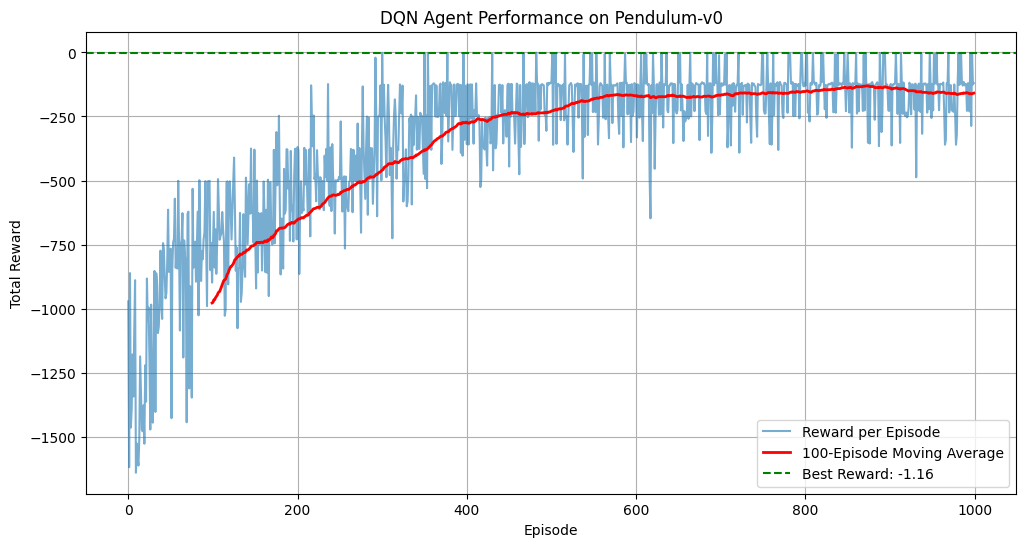

Average reward over the last 100 episodes: -158.89
Final model weights saved to dqn_pendulum_final_weights.pth
The model with the best reward (-1.16 at episode 894) was saved to dqn_pendulum_best_reward_weights.pth

Running demonstration with the BEST performing agent (from episode 894)...
Total reward in demonstration episode: -2.67


C:\Users\p2435356\AppData\Local\Temp\ipykernel_16388\2346917807.py:318: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_agent.policy_net.load_state_dict(torch.load(BES

In [5]:
# =============================================================================
# --- ST1504 DEEP LEARNING: ASSIGNMENT 2, PART B ---
#
# Task: Apply a Deep Q-Network (DQN) to solve the Pendulum-v0 environment.
#
# This script implements a DQN agent to balance an inverted pendulum.
# Key challenges addressed:
# 1.  Adapting DQN for a continuous action space via discretization.
# 2.  Implementing core DQN components: Replay Memory and a Target Network.
# 3.  Structuring the code for systematic hyperparameter tuning and evaluation.
#
# MODIFICATION: This version saves the model weights corresponding to the
# episode that achieved the HIGHEST (best) total reward during training.
#
# Environment: OpenAI Gym 0.17.3, Pendulum-v0
# Framework: PyTorch
# =============================================================================

# --- 1. SETUP AND IMPORTS ---
# Import necessary libraries.
# Ensure you have the correct versions installed, especially gym==0.17.3.
# pip install gym==0.17.3 torch matplotlib numpy

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque
import math
import matplotlib.pyplot as plt

# --- 2. HYPERPARAMETERS AND CONFIGURATION ---
# Centralizing hyperparameters makes them easy to find and tune, which is
# crucial for the systematic optimization required by the assignment. [2]

# Environment settings
ENV_NAME = 'Pendulum-v0'
# Per the assignment, ensure gym version 0.17.3 is used. [2]
env = gym.make(ENV_NAME)
STATE_DIM = env.observation_space.shape[0]  # Should be 3 for Pendulum-v0
ACTION_MAX = env.action_space.high[0]      # Max torque, typically 2.0
ACTION_MIN = env.action_space.low[0]       # Min torque, typically -2.0

# Discretization settings
# The core modification to apply DQN to this continuous environment. [2, 2]
# We will test if 5 bins is sufficient, as prompted in the notes. [2]
N_ACTION_BINS = 5

# DQN Agent hyperparameters
GAMMA = 0.99  # Discount factor for future rewards [3, 4]
LEARNING_RATE = 1e-3  # Learning rate for the Adam optimizer [5, 4]
BATCH_SIZE = 128  # Number of transitions sampled from the replay buffer [3, 4]
REPLAY_BUFFER_SIZE = 10000  # Max size of the replay buffer [5, 6]
TARGET_UPDATE_FREQUENCY = 500  # Steps between updating the target network [7, 5]

# Epsilon-greedy exploration strategy settings
EPS_START = 1.0  # Starting value of epsilon
EPS_END = 0.01  # Minimum value of epsilon
EPS_DECAY = 0.995  # Multiplicative factor for decaying epsilon per episode [3]

# Training settings
N_EPISODES = 1000  # Total number of episodes to train for
SEED = 42  # Random seed for reproducibility [8, 9]

# Set seed for all random number generators to ensure reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
env.seed(SEED)

# --- 3. ACTION SPACE DISCRETIZATION ---
# DQN requires a discrete action space. We convert the continuous torque
# range [-2.0, 2.0] into a finite number of bins. [10, 11]
discrete_action_space = np.linspace(ACTION_MIN, ACTION_MAX, N_ACTION_BINS)
print(f"State dimension: {STATE_DIM}")
print(f"Number of discrete actions: {N_ACTION_BINS}")
print(f"Discrete action space: {discrete_action_space}")


# --- 4. REPLAY MEMORY IMPLEMENTATION ---
# Stores agent's experiences to sample from for training. This breaks
# temporal correlations and improves data efficiency. [3, 12, 9]

# A named tuple to represent a single transition
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of the memory"""
        return len(self.memory)


# --- 5. DQN MODEL (Q-NETWORK) IMPLEMENTATION ---
# A simple Multi-Layer Perceptron (MLP) to approximate the Q-function.
# It takes a state and outputs a Q-value for each discrete action. [8, 3, 13]

class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        # A simple two-layer MLP is a good starting point for classic control. [8]
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


# --- 6. DQN AGENT IMPLEMENTATION ---
# Encapsulates the agent's logic: acting, learning, and managing networks.

class DQNAgent:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.epsilon = EPS_START

        # Initialize policy and target networks
        self.policy_net = QNetwork(state_dim, n_actions)
        self.target_net = QNetwork(state_dim, n_actions)
        self.update_target_net()  # Copy weights initially
        self.target_net.eval()  # Target network is only for inference

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(REPLAY_BUFFER_SIZE)
        self.steps_done = 0

    def select_action(self, state):
        """Selects an action using an epsilon-greedy policy."""
        if random.random() > self.epsilon:
            # Exploitation: choose the best action from the policy network
            with torch.no_grad():
                # state is a numpy array, convert to tensor for the network
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                # .max(1) returns (values, indices)
                return q_values.max(1)[1].item()
        else:
            # Exploration: choose a random action
            return random.randrange(self.n_actions)

    def learn(self):
        """Update the policy network using a batch of experiences."""
        if len(self.memory) < BATCH_SIZE:
            return  # Not enough experiences to learn yet

        # Sample a batch of transitions
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for details)
        batch = Transition(*zip(*transitions))

        # Create tensors for states, actions, rewards, and next_states
        state_batch = torch.FloatTensor(np.array(batch.state))
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1)

        # Handle non-final states
        non_final_mask = torch.tensor(tuple(s is not None for s in batch.next_state), dtype=torch.bool)
        non_final_next_states = torch.FloatTensor(np.array([s for s in batch.next_state if s is not None]))

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        next_state_values = torch.zeros(BATCH_SIZE)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        # Compute the expected Q values (TD Target)
        expected_state_action_values = (next_state_values.unsqueeze(1) * GAMMA) + reward_batch

        # Compute loss (Huber loss is often more stable than MSE)
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent them from exploding
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_net(self):
        """Copies the weights from the policy network to the target network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """Decay epsilon for the epsilon-greedy policy."""
        self.epsilon = max(EPS_END, self.epsilon * EPS_DECAY)


# --- 7. TRAINING LOOP ---
# This is the main loop where the agent interacts with the environment.

agent = DQNAgent(STATE_DIM, N_ACTION_BINS)
episode_rewards = []

# Variables to track and save the model with the best reward
best_reward_so_far = float('-inf')
episode_of_best_reward = -1
BEST_REWARD_MODEL_PATH = 'dqn_pendulum_best_reward_weights.pth'

print("\nStarting Training...")
for i_episode in range(N_EPISODES):
    state = env.reset()
    total_reward = 0
    
    # Pendulum-v0 runs for a fixed 200 steps per episode [2]
    for t in range(200):
        # Select and perform an action
        action_index = agent.select_action(state)
        torque_value = discrete_action_space[action_index]
        
        # The action passed to env.step must be a list or numpy array
        next_state, reward, done, _ = env.step([torque_value])
        total_reward += reward

        # Store the transition in replay memory
        # Note: action is the index, not the torque value
        agent.memory.push(state, action_index, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.learn()
        
        agent.steps_done += 1
        # Update the target network, copying all weights and biases in DQN
        if agent.steps_done % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_net()

        if done:
            break
            
    # Decay epsilon after each episode
    agent.decay_epsilon()
    
    episode_rewards.append(total_reward)

    # --- MODIFICATION: SAVE MODEL WITH BEST REWARD ---
    # Check if the current episode's reward is the best seen so far.
    if total_reward > best_reward_so_far:
        best_reward_so_far = total_reward
        episode_of_best_reward = i_episode + 1
        # Save the policy network's weights.
        torch.save(agent.policy_net.state_dict(), BEST_REWARD_MODEL_PATH)
        # Log that a new best reward model has been saved.
        print(f"** New best reward of {total_reward:.2f} found at episode {i_episode+1}. Model saved to {BEST_REWARD_MODEL_PATH} **")

    # Logging
    if (i_episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {i_episode+1}/{N_EPISODES} | Avg Reward (Last 100): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f}")

print("Training complete.\n")


# --- 8. EVALUATION AND VISUALIZATION ---
# Plotting the results is crucial to evaluate the agent's performance. [2, 2]

plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Reward per Episode', alpha=0.6)
# Calculate and plot a moving average to see the trend
if len(episode_rewards) >= 100:
    moving_avg = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
    plt.plot(np.arange(99, len(episode_rewards)), moving_avg, label='100-Episode Moving Average', color='red', linewidth=2)
plt.title('DQN Agent Performance on Pendulum-v0')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.axhline(y=best_reward_so_far, color='green', linestyle='--', label=f'Best Reward: {best_reward_so_far:.2f}')
plt.legend()
plt.grid(True)
plt.show()

if len(episode_rewards) >= 100:
    final_avg_reward = np.mean(episode_rewards[-100:])
    print(f"Average reward over the last 100 episodes: {final_avg_reward:.2f}")


# --- 9. SAVING THE MODEL ---
# The model with the best reward has already been saved during training.
# We will also save the final model state for comparison.
FINAL_MODEL_PATH = 'dqn_pendulum_final_weights.pth'
torch.save(agent.policy_net.state_dict(), FINAL_MODEL_PATH)
print(f"Final model weights saved to {FINAL_MODEL_PATH}")
print(f"The model with the best reward ({best_reward_so_far:.2f} at episode {episode_of_best_reward}) was saved to {BEST_REWARD_MODEL_PATH}")


# --- 10. DEMONSTRATION OF THE TRAINED AGENT ---
# Load the saved BEST REWARD weights and watch the agent perform.

# Create a new agent and load the weights
# NOTE: We are loading the model with the BEST reward as requested.
trained_agent = DQNAgent(STATE_DIM, N_ACTION_BINS)
try:
    trained_agent.policy_net.load_state_dict(torch.load(BEST_REWARD_MODEL_PATH))
    trained_agent.policy_net.eval()  # Set to evaluation mode

    print(f"\nRunning demonstration with the BEST performing agent (from episode {episode_of_best_reward})...")
    state = env.reset()
    # env.render() # Uncomment this line to see the visualization
    total_reward_demo = 0

    for t in range(200):
        # In demonstration, we only exploit, no exploration
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = trained_agent.policy_net(state_tensor)
            action_index = q_values.max(1)[1].item()
            
        torque_value = discrete_action_space[action_index]
        state, reward, done, _ = env.step([torque_value])
        total_reward_demo += reward
        # env.render() # Uncomment this line to see the visualization
        if done:
            break

    print(f"Total reward in demonstration episode: {total_reward_demo:.2f}")
except FileNotFoundError:
    print(f"Could not find the model file at {BEST_REWARD_MODEL_PATH}. Skipping demonstration.")

env.close()